In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import ( StratifiedKFold, RepeatedStratifiedKFold,
                                     GridSearchCV, KFold )
from sklearn.metrics import f1_score, roc_auc_score 
from collections import Counter 

In [2]:
warnings.simplefilter(action='ignore')
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams["figure.figsize"] = (12, 6)
sns.set(context="paper", font="monospace") 

In [3]:
def check_stats(data):
    stats = []
    for col in data.columns:
        stats.append((col, data[col].nunique(), data[col].isnull().sum() * 100 / data.shape[0],
                    round((data[col].value_counts(normalize=True, dropna=False).values[0] * 100),2), 
                    data[col].dtype))
        
    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'missing values %', 
                                            'biggest category %', 'type']) 
    return stats_df.sort_values('missing values %', ascending=False) 

In [4]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')
sub_df = pd.read_csv('SampleSubmission.csv') 
print(train_df.shape, test_df.shape) 

(1568, 27) (672, 26)


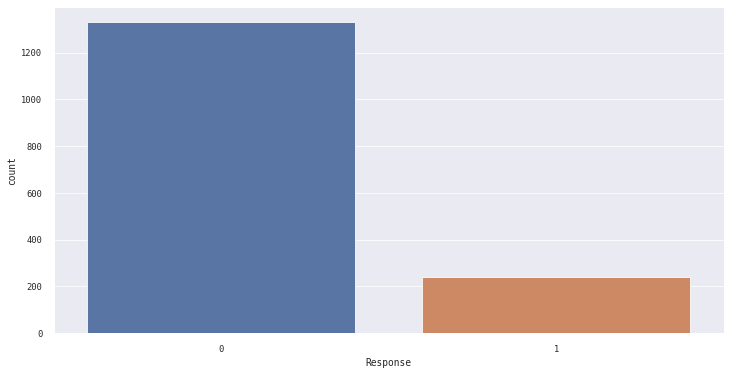

In [5]:
sns.countplot(train_df['Response']); 

In [6]:
train_df['Marital_Status'].value_counts() 

Married     615
Together    409
Single      329
Divorced    159
Widow        50
Alone         3
YOLO          2
Absurd        1
Name: Marital_Status, dtype: int64

In [7]:
test_df['Marital_Status'].value_counts() 

Married     249
Together    171
Single      151
Divorced     73
Widow        27
Absurd        1
Name: Marital_Status, dtype: int64

In [8]:
for i in ['Absurd', 'YOLO']: 
    train_df.loc[train_df['Marital_Status'] == i, ['Marital_Status']] = 'others'
    test_df.loc[test_df['Marital_Status'] == i, ['Marital_Status']] = 'others'

In [9]:
value = train_df['Disposable_Income'].median()
train_df.fillna(value, inplace=True)
test_df.fillna(value, inplace=True) 

In [10]:
# train_df['Disposable_Income'] = train_df['Disposable_Income'].interpolate(method="linear")
# test_df['Disposable_Income'] = test_df['Disposable_Income'].interpolate(method="linear")

In [11]:
ntrain = train_df.shape[0]

data = pd.concat((train_df, test_df)).reset_index(drop=True)
data['Date_Customer'] = pd.to_datetime(data['Date_Customer'])
data['date_year'] = data['Date_Customer'].dt.year
data['date_month'] = data['Date_Customer'].dt.month
data['date_quat'] = data['Date_Customer'].dt.quarter 
data['date_day'] = data['Date_Customer'].dt.day 

In [12]:
data['rec_web'] = data['Recency'] / (data['WebVisitsMonth'] + 1)
data['meat_cat'] = data['Amount_on_MeatProducts'] / (data['CatalogPurchases'] + 1)
data['yearly_expenses'] = (data[['Amount_on_Fruits', 'Amount_on_MeatProducts', 'Amount_on_FishProducts',
                                'Amount_on_SweetProducts', 'Amount_on_GoldProds']].sum(axis=1)) / 3
data['spending_ratio'] = data['Disposable_Income'] / data['yearly_expenses'] 

In [13]:
check_stats(data)

,Feature,Unique_values,missing values %,biggest category %,type
26,Response,2,30.0,59.33,float64
0,ID,2240,0.0,0.04,object
20,Cmp3Accepted,2,0.0,92.72,int64
21,Cmp4Accepted,2,0.0,92.54,int64
22,Cmp5Accepted,2,0.0,92.72,int64
23,Cmp1Accepted,2,0.0,93.57,int64
24,Cmp2Accepted,2,0.0,98.66,int64
25,Any_Complain,2,0.0,99.06,int64
27,date_year,3,0.0,53.08,int64
18,Amount_on_GoldProds,213,0.0,3.26,int64


In [14]:
# drop_list = [f'Cmp{i}Accepted' for i in range(1,6)]
# # drop_list = drop_list + ['Any_Complain', 'Disposable_Income','WebVisitsMonth','Year_of_Birth'] 
# drop_list = drop_list + ['Any_Complain'] 
# data.drop(drop_list, axis=1, inplace=True) 

In [15]:
# data['Disposable_Income'] = data['Disposable_Income'].interpolate(method="linear")

In [16]:
for feat in ['Marital_Status', 'Education_Level']:
    data[feat] = pd.factorize(data[feat])[0] 

In [17]:
data.drop(['ID', 'Date_Customer'], axis=1, inplace=True) 

In [18]:
train = data[:ntrain]
test = data[ntrain:]
target = train['Response'] 
print(train.shape, test.shape, target.shape) 

(1568, 33) (672, 33) (1568,)


In [19]:
train.drop('Response', axis=1, inplace=True)
test.drop('Response', axis=1, inplace=True)
print(train.shape, test.shape, target.shape) 

(1568, 32) (672, 32) (1568,)


### Xgb 

In [20]:
weight = Counter(target)[0] / Counter(target)[1]
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24) 
xgb_ = xgb.XGBClassifier(scale_pos_weight=weight, n_jobs=-1, max_depth=4, 
                        random_state=64, sub_sample=0.8, n_estimators=500,
                        gamma=1, min_child_weight=10, colsample_bytree=0.8) 


In [21]:
mean_train, mean_test_val = [], []
test_pred = np.zeros(test.shape[0])
val_pred = np.zeros(train.shape[0])


for fold, (train_index, test_index) in enumerate(skf.split(train, target)):
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    print(f'=====================Fold{fold +1}=====================')
    xgb_.fit(X_train, y_train, early_stopping_rounds=200, eval_metric='auc',
            eval_set=[(X_test, y_test)], verbose=250)
    train_predict = xgb_.predict_proba(X_train)[:,1]
    test_predict = xgb_.predict_proba(X_test)[:,1]
    val_pred[test_index] = test_predict
    test_pred += xgb_.predict_proba(test)[:,1]

    print(f'\nTrain score: {roc_auc_score(y_train, train_predict)}')
    print(f'\nTest score: {roc_auc_score(y_test, test_predict)}')

    mean_train.append(roc_auc_score(y_train, train_predict))
    mean_test_val.append(roc_auc_score(y_test, test_predict))

test_pred = test_pred / 10
print(f'Average Train score for 10 folds split: {np.mean(mean_train)}') 
print(f'Average Test score for 10 folds split: {np.mean(mean_test_val)}')
print(f'Standard deviation for 10 folds split: {np.std(mean_test_val)}') 

=====================Fold1=====================
[08:11:52] WARNING: ../src/learner.cc:573: 
Parameters: { "sub_sample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79120
[218]	validation_0-auc:0.88409

Train score: 0.9824453605040057

Test score: 0.9035087719298245
=====================Fold2=====================
[08:11:52] WARNING: ../src/learner.cc:573: 
Parameters: { "sub_sample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77976
[213]	validation_0-auc:0.87218

Train score: 0.9712549583884265

Test score: 0.8984962

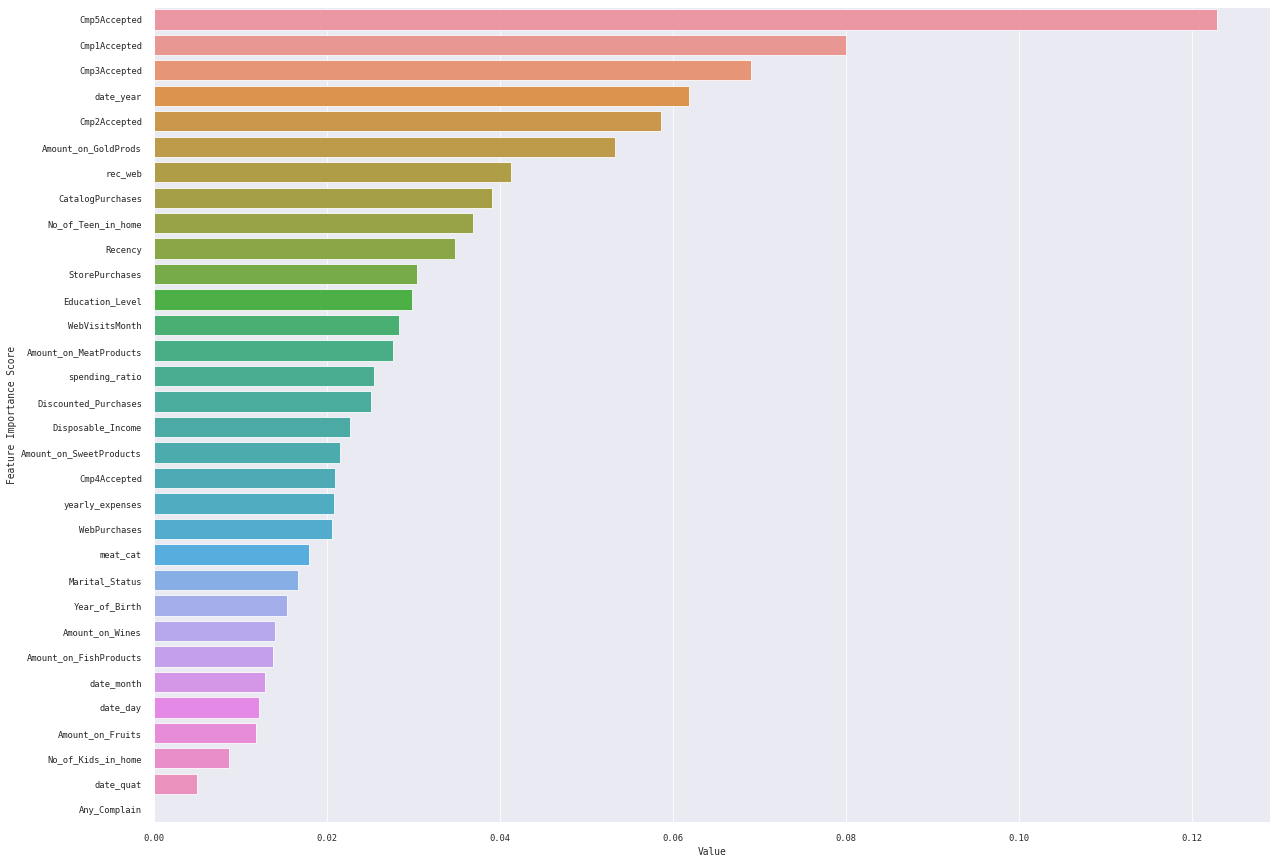

In [22]:
feat_imp = pd.DataFrame(sorted(zip(xgb_.feature_importances_, train.columns)),
                                columns=['Value', 'Feature'])
plt.figure(figsize=(20, 15))
imp_data = feat_imp.sort_values(by="Value", ascending=False)
sns.barplot(x="Value", y="Feature", data=imp_data.iloc[:50])
plt.ylabel('Feature Importance Score')
plt.show() 

In [23]:
pd.Series(test_pred).describe() 

count    672.000000
mean       0.253034
std        0.247304
min        0.025796
25%        0.062912
50%        0.138714
75%        0.381589
max        0.957333
dtype: float64

In [24]:
threshold = 0.42
predictions = [1 if p > threshold else 0 for p in test_pred] 

In [25]:
sub_df['Response'] = predictions
sub_df['Response'].value_counts() 

0    517
1    155
Name: Response, dtype: int64

In [26]:
sub_df.to_csv('csv/new-xgboost.csv', index=False)  